# Predicting car prices with K-Nearest Neighbors

In this small project, we will practice the scikit-learn workflow. We will build an [instance-based](https://en.wikipedia.org/wiki/Instance-based_learning) model to predict car prices based on the dataset found [here](https://archive.ics.uci.edu/ml/datasets/automobile) at the Machine Learning Repository. More specifically, we will train a K-Nearest Neighbors (KNN) model and validate it by using cross validation.

First, we load the dataframe with the correct column names. We also determined which columns are numeric and thus can be used as features.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

col_names = ['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration', 'num_doors', 'body_style', 'drive_wheels', 'engine_location', 'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_type', 'num_cylinders', 'engine_size', 'fuel_system', 'bore', 'stroke', 'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price']
data = pd.read_csv('imports-85.data', header = None, names=col_names)

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized_losses    205 non-null object
make                 205 non-null object
fuel_type            205 non-null object
aspiration           205 non-null object
num_doors            205 non-null object
body_style           205 non-null object
drive_wheels         205 non-null object
engine_location      205 non-null object
wheel_base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb_weight          205 non-null int64
engine_type          205 non-null object
num_cylinders        205 non-null object
engine_size          205 non-null int64
fuel_system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression_ratio    205 non-null float64
horsepower           205 non-nul

In [3]:
possible_features = ['symboling', 'normalized_losses', 'num_doors', 'wheel_base', 'length', 'width', 'height', 'curb_weight', 'num_cylinders', 'engine_size', 'bore', 'stroke', 'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg']

In [4]:
data.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


## Exploratory data analysis and cleaning

The KNN model cannot deal with missing values, so we deal with those next. We will look for missing values and either replace them or remove the corresponding rows, depending on how many missing values are there. More precisely, if there are only a few missing values, we will remove the corresponding rows, but if there are many, we will have to think of other strategies.

Columns containing the '?' string where automatically cast as the object type. We will convert to numeric type where appropriate.

In [5]:
data.replace(to_replace='?', value=np.nan, inplace=True)

In [6]:
data['normalized_losses'] = data['normalized_losses'].astype(float)
data['bore'] = data['bore'].astype(float)
data['stroke'] = data['stroke'].astype(float)
data['horsepower'] = data['horsepower'].astype(float)
data['peak_rpm'] = data['peak_rpm'].astype(float)
data['price'] = data['price'].astype(float)

In [7]:
def analyze_nans(col_name):
    nr_nans = sum(data[col_name].isna())
    nr_rows = len(data[col_name])
    percent = nr_nans / nr_rows
    
    print('Number of NaNs in {0} column: {1}\nNumber of rows: {2}\nPercentage of NaN rows in {0} column: {3}'.format(col_name,nr_nans, nr_rows,percent))

In [8]:
analyze_nans('normalized_losses')

Number of NaNs in normalized_losses column: 41
Number of rows: 205
Percentage of NaN rows in normalized_losses column: 0.2


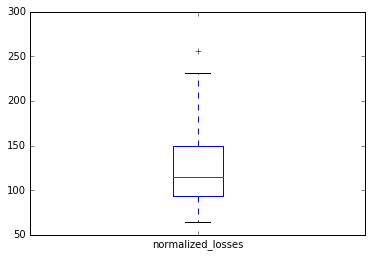

In [9]:
data['normalized_losses'].plot.box()

The data in the _normalized_\__losses_ column is not highly concentrated around its mean, so replacing the missing values with the column mean would alter the column statistics considerably. Thus, we opt for dropping the column.

In [10]:
data.drop('normalized_losses', axis=1, inplace=True, errors='ignore')
possible_features.remove('normalized_losses')
data.columns

Index(['symboling', 'make', 'fuel_type', 'aspiration', 'num_doors',
       'body_style', 'drive_wheels', 'engine_location', 'wheel_base', 'length',
       'width', 'height', 'curb_weight', 'engine_type', 'num_cylinders',
       'engine_size', 'fuel_system', 'bore', 'stroke', 'compression_ratio',
       'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price'],
      dtype='object')

Next we look for NaNs in the _bore_ and _stroke_ columns.

In [11]:
analyze_nans('bore')

Number of NaNs in bore column: 4
Number of rows: 205
Percentage of NaN rows in bore column: 0.01951219512195122


In [12]:
analyze_nans('stroke')

Number of NaNs in stroke column: 4
Number of rows: 205
Percentage of NaN rows in stroke column: 0.01951219512195122


In [13]:
data.loc[data['stroke'].isna(), ['stroke', 'bore']]

,stroke,bore
55,NaN,NaN
56,NaN,NaN
57,NaN,NaN
58,NaN,NaN


We can safely drop these four rows since they share NaNs both for the _stroke_ and _bore_ columns.

In [14]:
data.dropna(subset=['stroke', 'bore'], inplace=True)
analyze_nans('stroke')
analyze_nans('bore')

Number of NaNs in stroke column: 0
Number of rows: 201
Percentage of NaN rows in stroke column: 0.0
Number of NaNs in bore column: 0
Number of rows: 201
Percentage of NaN rows in bore column: 0.0


Next we look for NaNs in the _horsepower_ and _peak_\__rpm_ columns.

In [15]:
analyze_nans('horsepower')

Number of NaNs in horsepower column: 2
Number of rows: 201
Percentage of NaN rows in horsepower column: 0.009950248756218905


In [16]:
analyze_nans('peak_rpm')

Number of NaNs in peak_rpm column: 2
Number of rows: 201
Percentage of NaN rows in peak_rpm column: 0.009950248756218905


In [17]:
data.loc[data['horsepower'].isna(), ['horsepower', 'peak_rpm']]

,horsepower,peak_rpm
130,NaN,NaN
131,NaN,NaN


Again, we can drop the two rows since they share NaNs for the _horsepower_ and _peak_\__rpm_ columns.

In [18]:
data.dropna(subset=['horsepower', 'peak_rpm'], inplace=True)
analyze_nans('horsepower')
analyze_nans('peak_rpm')

Number of NaNs in horsepower column: 0
Number of rows: 199
Percentage of NaN rows in horsepower column: 0.0
Number of NaNs in peak_rpm column: 0
Number of rows: 199
Percentage of NaN rows in peak_rpm column: 0.0


Finally, we look for NaNs in the target column _price_.

In [19]:
analyze_nans('price')

Number of NaNs in price column: 4
Number of rows: 199
Percentage of NaN rows in price column: 0.020100502512562814


In [20]:
data.loc[data['price'].isna(), :]

,symboling,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
9,0,audi,gas,turbo,two,hatchback,4wd,front,99.5,178.2,...,131,mpfi,3.13,3.40,7.0,160.0,5500.0,16,22,NaN
44,1,isuzu,gas,std,two,sedan,fwd,front,94.5,155.9,...,90,2bbl,3.03,3.11,9.6,70.0,5400.0,38,43,NaN
45,0,isuzu,gas,std,four,sedan,fwd,front,94.5,155.9,...,90,2bbl,3.03,3.11,9.6,70.0,5400.0,38,43,NaN
129,1,porsche,gas,std,two,hatchback,rwd,front,98.4,175.7,...,203,mpfi,3.94,3.11,10.0,288.0,5750.0,17,28,NaN


We will also drop this rows, because without a target we cannot train or validate our model.

In [21]:
data.dropna(subset=['price'], inplace=True)

Next, we convert the _num_\__doors_ and _num_\__cylinders_ from string to numeric types and deal with their NaNs.

In [22]:
number_map = {'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10, 'eleven': 11, 'twelve': 12}

In [23]:
data['num_doors'] = data['num_doors'].map(number_map)
data['num_cylinders'] = data['num_cylinders'].map(number_map)

In [24]:
analyze_nans('num_doors')

Number of NaNs in num_doors column: 2
Number of rows: 195
Percentage of NaN rows in num_doors column: 0.010256410256410256


In [25]:
analyze_nans('num_cylinders')

Number of NaNs in num_cylinders column: 0
Number of rows: 195
Percentage of NaN rows in num_cylinders column: 0.0


In [26]:
data.dropna(subset=['num_doors'], inplace=True)

### Normalizing the numeric values

Since the values in different columns have completely different ranges, we normalize them by centering on their mean and dividing by their standard deviation. In this way, each column will represent a distribution with zero mean and unitary standard deviation.

In [27]:
# Sanity check that all possible features are now numeric values
data[possible_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 0 to 204
Data columns (total 16 columns):
symboling            193 non-null int64
num_doors            193 non-null float64
wheel_base           193 non-null float64
length               193 non-null float64
width                193 non-null float64
height               193 non-null float64
curb_weight          193 non-null int64
num_cylinders        193 non-null int64
engine_size          193 non-null int64
bore                 193 non-null float64
stroke               193 non-null float64
compression_ratio    193 non-null float64
horsepower           193 non-null float64
peak_rpm             193 non-null float64
city_mpg             193 non-null int64
highway_mpg          193 non-null int64
dtypes: float64(10), int64(6)
memory usage: 25.6 KB


In [28]:
# Subtract mean and divide by standard deviation
data[possible_features] = (data[possible_features] - data[possible_features].mean()) / data[possible_features].std()

In [29]:
data[possible_features].head()

,symboling,num_doors,wheel_base,length,width,height,curb_weight,num_cylinders,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
0,1.782215,-1.172839,-1.678015,-0.442872,-0.839080,-2.117092,-0.025646,-0.410180,0.045098,0.511697,-1.803495,-0.287525,0.198054,-0.212806,-0.677292,-0.555613
1,1.782215,-1.172839,-1.678015,-0.442872,-0.839080,-2.117092,-0.025646,-0.410180,0.045098,0.511697,-1.803495,-0.287525,0.198054,-0.212806,-0.677292,-0.555613
2,0.163544,-1.172839,-0.719041,-0.250543,-0.184200,-0.613816,0.496473,1.544506,0.574066,-2.388614,0.701095,-0.287525,1.330822,-0.212806,-0.990387,-0.702307
3,0.972880,0.848214,0.142410,0.182198,0.143240,0.179580,-0.426254,-0.410180,-0.459826,-0.516262,0.479169,-0.036110,-0.039037,0.853987,-0.207649,-0.115531
4,0.972880,0.848214,0.077395,0.182198,0.236794,0.179580,0.498371,0.567163,0.189362,-0.516262,0.479169,-0.538940,0.303427,0.853987,-1.146935,-1.289083


## Univariate KNN models

We start by training and testing KNN models that are based on a single feature (univariate). This will help us setup a workflow and, more importantly, understand the features better.

In [30]:
from numpy.random import seed, permutation
from math import floor, sqrt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test(df=data, feature='highway_mpg', target='price'):
    data_copy = df[[feature, target]].copy()
    nr_rows = data_copy.shape[0]
    train_prop = 0.9
    data_copy = data_copy.iloc[permutation(nr_rows),:]
    
    train = data_copy.iloc[:floor(nr_rows * train_prop)]
    test = data_copy.iloc[floor(nr_rows * train_prop):]
    
    knn = KNeighborsRegressor(n_neighbors=5, algorithm='auto')
    knn.fit(train[[feature]], train[target])
    
    predictions = knn.predict(test[[feature]])
    return sqrt(mean_squared_error(predictions, test[target]))

We now test this simple model on all the features, one by one.

In [31]:
rmse = {}
for feature in possible_features:
    seed(1)
    rmse[feature] = knn_train_test(df=data, feature=feature, target='price')

In [32]:
rmse

{'bore': 7007.566073751999,
 'city_mpg': 2201.6814592488163,
 'compression_ratio': 4607.836303081957,
 'curb_weight': 3751.1983375982663,
 'engine_size': 1964.288217650353,
 'height': 6204.371818000594,
 'highway_mpg': 3009.797927768574,
 'horsepower': 1910.7680058029023,
 'length': 3216.856305463457,
 'num_cylinders': 2415.4297712829493,
 'num_doors': 8460.627011634539,
 'peak_rpm': 4672.850484875372,
 'stroke': 3041.003005259942,
 'symboling': 4956.493094921045,
 'wheel_base': 2348.6095827105873,
 'width': 1316.9233994428077}

### Conclusions
We conclude that, in this simple setting, the _width_ is the best single predictor of the _price_ column. However, _engine_\__size_ and _horsepower_ also produce low Root Mean Square Errors (RMSEs).

Next, we perform hyperparameter optimization via grid search. To do so, we modify our model above to accept the number of neighbors k as an additional input.

In [33]:
def knn_different_nbhs(df=data, feature='highway_mpg', target='price', nr_nbhs=5):
    data_copy = df[[feature, target]].copy()
    nr_rows = data_copy.shape[0]
    train_prop = 0.9
    data_copy = data_copy.iloc[permutation(nr_rows),:]
    
    train = data_copy.iloc[:floor(nr_rows * train_prop)]
    test = data_copy.iloc[floor(nr_rows * train_prop):]
    
    knn = KNeighborsRegressor(n_neighbors=nr_nbhs, algorithm='auto')
    knn.fit(train[[feature]], train[target])
    
    predictions = knn.predict(test[[feature]])
    return sqrt(mean_squared_error(predictions, test[target]))

In [34]:
rmse_different_nbhs = {}

for feature in possible_features:
    rmse_different_nbhs[feature] = []
    
for feature in possible_features:
    for nr in [1, 3, 5, 7, 9]:
        seed(1)
        rmse_different_nbhs[feature].append(knn_different_nbhs(df=data, feature=feature, target='price', nr_nbhs=nr))

## Hyperparameter plots

To perform hyperparameter optimization, we create a function that plots the various RMSEs for different number of neighbours in the KNN algorithm.

In [35]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

def plot_hyperparam(feature_name):
    plt.plot([1, 3, 5, 7, 9], rmse_different_nbhs[feature_name])
    plt.title('Hyperparameter optimization for\n' + feature_name, y=1.05)
    plt.xticks([1, 3, 5, 7, 9])
    plt.xlim((0.5,9.5))
    plt.xlabel('Number of neighbors')
    plt.ylabel('RMSE')
    plt.show()

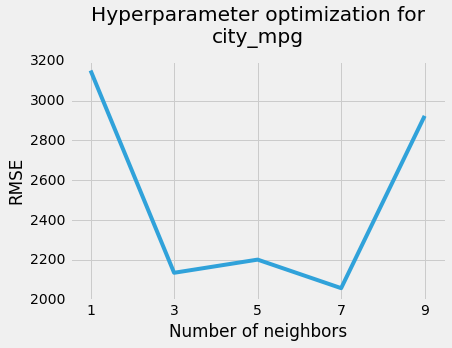

In [36]:
plot_hyperparam('city_mpg')

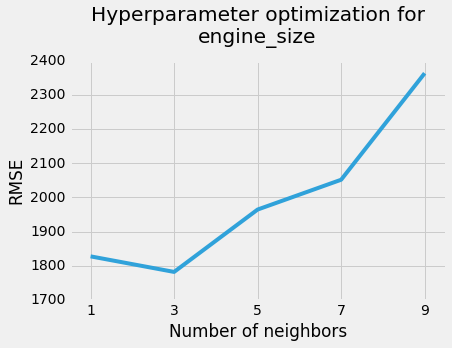

In [37]:
plot_hyperparam('engine_size')

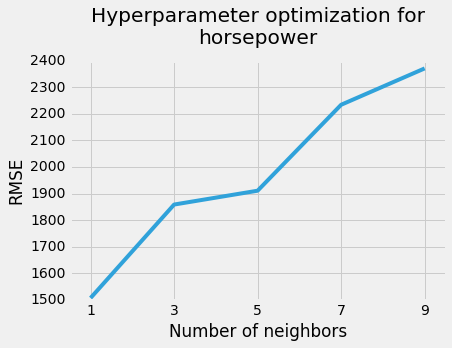

In [38]:
plot_hyperparam('horsepower')

## Multivariate KNN models

Next we increase the complexity of our model by training and testing KNN models that are based on multiple features (multivariate). We will use our earlier functions as a base for the new workflow. 

We will test our model with the best n features for the univariate model, where n will be taken to be 2, 3, 4 and 5. The respective features are
* (n=2) _width_, _horsepower_
* (n=3) _width_, _horsepower_, _engine_\__size_
* (n=4) _width_, _horsepower_, _engine_\__size_, _city_\__mpg_
* (n=5) _width_, _horsepower_, _engine_\__size_, _city_\__mpg_, _wheel_\__base_

In [39]:
def knn_multivariate(df=data, features=['width', 'horsepower'], target='price', nr_nbhs=5):
    features.append(target)
    data_copy = df[features].copy()
    nr_rows = data_copy.shape[0]
    train_prop = 0.9
    data_copy = data_copy.iloc[permutation(nr_rows),:]
    
    train = data_copy.iloc[:floor(nr_rows * train_prop)]
    test = data_copy.iloc[floor(nr_rows * train_prop):]
    
    features.remove(target)
    knn = KNeighborsRegressor(n_neighbors=nr_nbhs, algorithm='auto')
    knn.fit(train[features], train[target])
    
    predictions = knn.predict(test[features])
    return sqrt(mean_squared_error(predictions, test[target]))

In [40]:
top_features = ['width', 'horsepower', 'engine_size', 'city_mpg', 'wheel_base']
rmse_multivariate = {2: 0, 3: 0, 4: 0, 5: 0}

for n in range(2, 6):
    seed(1)
    rmse_multivariate[n] = knn_multivariate(df=data, features=top_features[:n], target='price', nr_nbhs=5)

rmse_multivariate

{2: 1265.8933746568073,
 3: 1996.251006261487,
 4: 2250.5026540753065,
 5: 1720.6803026710106}

### Conclusions

The optimization procedure shows that it's best to use only two features. Using more results in overfitting, and thus a high variance (but low bias).

Next we perform hyperparameter optimization on the best (n=2) model that we identified above. We will vary the number of neighbors used by the model between 1 and 25 and choose the best one.

In [47]:
hyperparams = list(range(1,26))
rmse_different_hyperparams = {param: 0 for param in hyperparams}

for par in hyperparams:
    rmse_different_hyperparams[par] = knn_multivariate(df=data, features=top_features[:2], target='price', nr_nbhs=par)

rmse_different_hyperparams

{1: 2611.3542655105225,
 2: 3306.0621137540656,
 3: 3154.117620050196,
 4: 2771.353693932804,
 5: 2650.322787888298,
 6: 1959.595422742494,
 7: 1928.3155041832413,
 8: 2969.329259277253,
 9: 5630.302751272586,
 10: 4421.773562723447,
 11: 2170.7641255656904,
 12: 5189.2103439158045,
 13: 4235.98334754872,
 14: 3271.2339932776913,
 15: 3360.6096111006736,
 16: 2710.452714362838,
 17: 4578.469667062843,
 18: 5496.685630413911,
 19: 2617.7375504891615,
 20: 6238.989221510564,
 21: 5436.244156036066,
 22: 5837.853089176344,
 23: 3767.2718360470044,
 24: 4757.452624120027,
 25: 6378.394976750813}

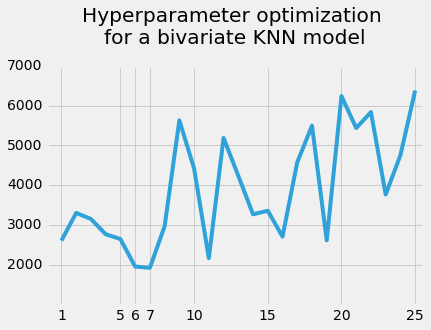

In [66]:
plt.plot(hyperparams, list(rmse_different_hyperparams.values()))
plt.title('Hyperparameter optimization \nfor a bivariate KNN model', y=1.07)
plt.xticks((1,5,6,7,10,15,20,25))
plt.yticks((2000, 3000, 4000, 5000, 6000, 7000))
plt.xlim((0,25.5))
plt.show()

## Conclusions

As expected, the performance of the model decreases as the number of neighbors increases. The optimal hyperparameter (number of neighbors) for this specific model is either 6 or 7.